In [2]:
#Figures and stats for VIIRS candidate fires for 2020 Western US fires
#Shane Coffield coffield@umd.edu March 2024
#runs on conda env:ml on discover

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import pandas as pd
import geopandas as gpd
import os
import datetime as dt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gs
import matplotlib.dates as mdates
import rasterio
import warnings
from scipy import stats

In [4]:
def scale_bar(ax, length=None, location=(0.15, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    credit: https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby+600, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [5]:
dets = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_clipped.csv')
dets.acq_date = pd.to_datetime(dets.acq_date)
dets

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,j,i750,j750,frp_old,frp,dist_m13b,fireid,Incid_Name
0,-122.536130,39.669617,5,D,x,2020-08-14,2136,1734,342,867,NaN,2.810732,0.640692,F11445,AUGUST COMPLEX
1,-122.556640,39.791810,5,D,x,2020-08-14,2136,1733,360,866,NaN,2.147372,0.526319,F11445,AUGUST COMPLEX
2,-122.674805,39.765137,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
3,-122.675780,39.768494,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
4,-122.691410,39.774660,8,N,n,2020-08-17,912,959,3114,479,2.454743,2.454743,NaN,F11445,AUGUST COMPLEX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342950,-121.353516,36.114807,5,D,x,2020-10-19,2054,3595,2143,1797,NaN,11.767087,NaN,F11716,DOLAN
342951,-121.356445,36.115295,7,D,l,2020-10-19,2054,3594,2144,1797,42.167553,42.167553,NaN,F11716,DOLAN
342952,-121.351560,36.109680,8,N,n,2020-10-20,918,1381,444,690,1.775952,1.775952,NaN,F11716,DOLAN
342953,-121.356445,36.112427,8,N,n,2020-10-20,918,1381,449,690,1.744053,1.744053,NaN,F11716,DOLAN


In [6]:
feds = gpd.read_file('/discover/nobackup/scoffie1/2020_feds_large_fires_named.geojson')
feds.startdate = pd.to_datetime(feds.startdate)
feds.enddate = pd.to_datetime(feds.enddate)
feds

,fireid,farea,startdate,enddate,Incid_Name,geometry
0,F11445,4493.471804,2020-08-17 00:00:00,2020-11-25 00:00:00,AUGUST COMPLEX,"POLYGON ((-123.53943 40.27585, -123.53955 40.2..."
1,F11440,1894.388484,2020-08-17 00:00:00,2020-10-29 12:00:00,LIONSHEAD,"POLYGON ((-122.63453 44.78792, -122.63473 44.7..."
2,F12649,1768.278704,2020-09-05 00:00:00,2020-11-26 00:00:00,CREEK,"POLYGON ((-119.50743 37.38098, -119.50743 37.3..."
3,F11393,1526.054850,2020-08-16 12:00:00,2020-09-27 12:00:00,SCU LIGHTNING COMPLEX,"POLYGON ((-121.81677 37.46370, -121.81680 37.4..."
4,F11527,1400.560920,2020-08-18 00:00:00,2020-10-29 12:00:00,CLAREMONT,"POLYGON ((-121.49817 39.64681, -121.49862 39.6..."
5,F11529,1264.748675,2020-08-18 00:00:00,2020-09-21 12:00:00,HENNESSEY,"POLYGON ((-122.59634 38.68418, -122.59686 38.6..."
6,F12774,1016.807124,2020-09-07 00:00:00,2020-10-02 12:00:00,COLD SPRINGS,"MULTIPOLYGON (((-120.01616 47.92316, -120.0153..."
7,F13515,962.841169,2020-08-13 12:00:00,2020-11-13 12:00:00,CAMERON PEAK,"POLYGON ((-105.91946 40.60147, -105.91961 40.6..."
8,F11825,934.392811,2020-08-20 12:00:00,2020-11-27 00:00:00,CASTLE,"POLYGON ((-118.83894 36.29807, -118.83931 36.2..."
9,F12981,804.268938,2019-10-03 00:00:00,2020-10-19 00:00:00,HOLIDAY FARM,"POLYGON ((-122.77847 44.15300, -122.77972 44.1..."


In [7]:
#first clip to +/- 1 day of FEDS fire lifetime
for fire in feds.index:
    start = feds.loc[fire,'startdate'] - dt.timedelta(days=1)
    end = feds.loc[fire,'enddate'] + dt.timedelta(days=1)
    
    subset = dets[dets.Incid_Name == feds.loc[fire, 'Incid_Name']].index
    dets.loc[subset,'within_time'] = (dets.loc[subset,'acq_date'] >= start) & (dets.loc[subset,'acq_date']<=end)

In [8]:
print('original n dets, time-clipped n dets:')
len(dets), dets.within_time.sum()

original n dets, time-clipped n dets:


(342955, 340660)

In [9]:
dets = dets[dets.within_time].reset_index(drop=True)
del dets['within_time']
dets.to_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_final.csv', index=False)
dets

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,j,i750,j750,frp_old,frp,dist_m13b,fireid,Incid_Name
0,-122.674805,39.765137,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
1,-122.675780,39.768494,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
2,-122.691410,39.774660,8,N,n,2020-08-17,912,959,3114,479,2.454743,2.454743,NaN,F11445,AUGUST COMPLEX
3,-122.685550,39.774353,8,N,n,2020-08-17,912,960,3114,480,5.806045,5.806045,NaN,F11445,AUGUST COMPLEX
4,-122.680664,39.774110,9,N,h,2020-08-17,912,961,3114,480,5.806045,5.806045,NaN,F11445,AUGUST COMPLEX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340655,-121.353516,36.114807,5,D,x,2020-10-19,2054,3595,2143,1797,NaN,11.767087,NaN,F11716,DOLAN
340656,-121.356445,36.115295,7,D,l,2020-10-19,2054,3594,2144,1797,42.167553,42.167553,NaN,F11716,DOLAN
340657,-121.351560,36.109680,8,N,n,2020-10-20,918,1381,444,690,1.775952,1.775952,NaN,F11716,DOLAN
340658,-121.356445,36.112427,8,N,n,2020-10-20,918,1381,449,690,1.744053,1.744053,NaN,F11716,DOLAN


In [12]:
#figure 3 - creek, august complex, beachie creek map and timeseries - separate day/night bars - DELETE
def map_and_timeseries(ax1, ax2, dets, firename, extent):
    subset = dets[dets.Incid_Name==firename]
    
    if firename=='OREGON FIRES': subset = dets[dets.Incid_Name.isin(['RIVERSIDE','LIONSHEAD'])]

    table = pd.DataFrame()
    
    start_date = pd.to_datetime('2020/08/17')
    while start_date < pd.to_datetime('2020/10/15'):
        table.loc[start_date, 'known'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask>=7) & (subset.daynight=='N')])
        table.loc[start_date, 'cand'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask<=6) & (subset.daynight=='N')])

        table.loc[start_date + dt.timedelta(hours=12), 'known'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask>=7) & (subset.daynight=='D')])
        table.loc[start_date + dt.timedelta(hours=12), 'cand'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask<=6) & (subset.daynight=='D')])
        
        start_date = start_date + dt.timedelta(1)
    
    ax1.set_extent(extent)
    ax1.scatter(subset.longitude, subset.latitude, c=subset.color, s=0.1, transform=ccrs.Geodetic()) #adjust size for fire
    ax1.set_title(firename.title())
    pct = (subset.fire_mask < 7).sum() / len(subset)
    ax1.annotate('{:.1f}%\ncandidates'.format(pct*100), xy=(0.6, 0.85),  size=10, xycoords=ax1.transAxes, color='deepskyblue')

    ax2.bar(table.index, table.known, width=0.5, color='firebrick', label='Known')
    ax2.bar(table.index, table.cand, width=0.5, color='deepskyblue', label='Candidates', bottom=table.known)
    #ax2.set_ylim((0,5000))
    ax2.set_ylabel('Number of detections')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    scale_bar(ax1, 10)

In [13]:
#figure 3 - creek, august complex, beachie creek map and timeseries
def map_and_timeseries(ax1, ax2, dets, firename, extent):
    subset = dets[dets.Incid_Name==firename]
    
    if firename=='OREGON FIRES': subset = dets[dets.Incid_Name.isin(['RIVERSIDE','LIONSHEAD'])]
    #subset = subset.sort_values('fire_mask', ascending=False) #put candidates on top
    
    table = pd.DataFrame()
    
    start_date = pd.to_datetime('2020/08/17')
    while start_date < pd.to_datetime('2020/10/15'):
        table.loc[start_date, 'known'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask>=7)])
        table.loc[start_date, 'cand'] = len(subset[(subset.acq_date==start_date) & (subset.fire_mask<=6)])

        start_date = start_date + dt.timedelta(1)
    
    ax1.set_extent(extent)
    ax1.scatter(subset.longitude, subset.latitude, c=subset.color, s=0.1, transform=ccrs.Geodetic()) #adjust size for fire
    ax1.set_title(firename.title())
    pct = (subset.fire_mask < 7).sum() / len(subset)
    ax1.annotate('{:.1f}%\ncandidates'.format(pct*100), xy=(0.6, 0.85),  size=10, xycoords=ax1.transAxes, color='deepskyblue')

    ax2.bar(table.index, table.known, width=1, color='firebrick', label='Known')
    ax2.bar(table.index, table.cand, width=1, color='deepskyblue', label='Candidates', bottom=table.known)
    #ax2.set_ylim((0,5000))
    ax2.set_ylabel('Number of detections')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    scale_bar(ax1, 10)

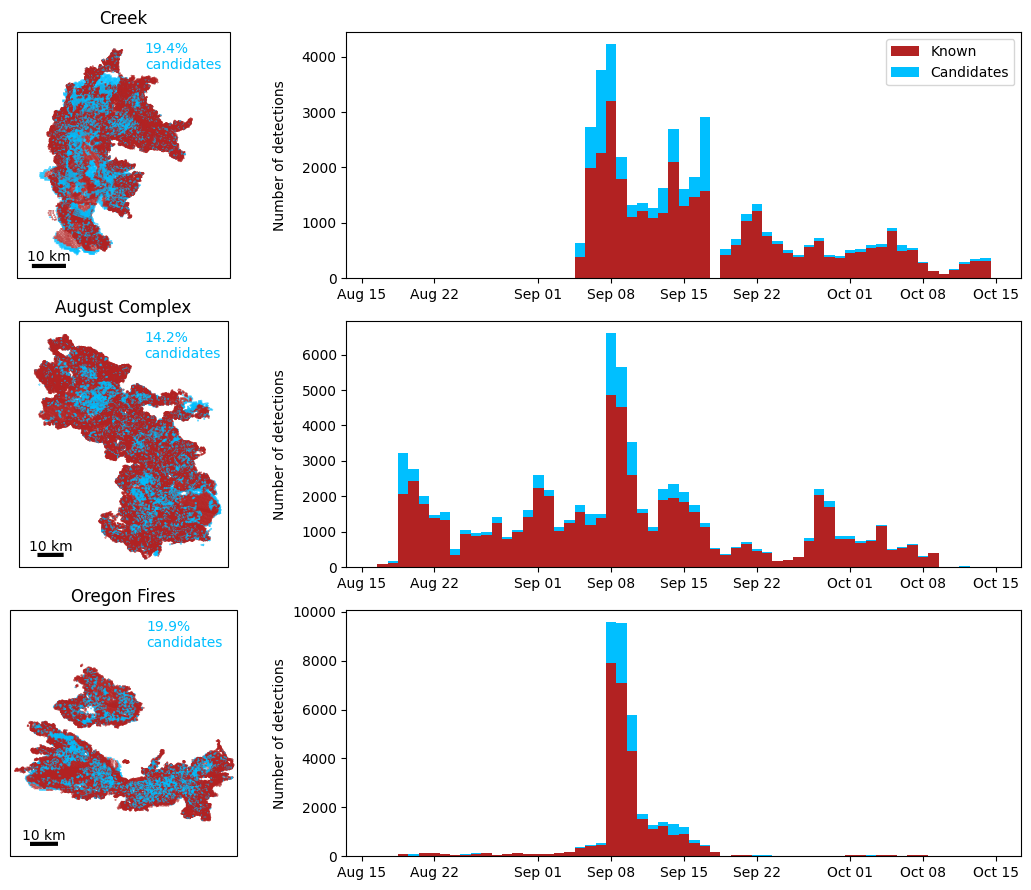

In [14]:
#figure 3 - creek, august complex, beachie creek map and timeseries
dets['color'] = 'firebrick'
dets.loc[dets.fire_mask < 7, 'color'] = 'deepskyblue'

fig = plt.figure(figsize=(11,9)) 
grid = gs.GridSpec(3,2, width_ratios=[1,2]) 

#creek
ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax2 = plt.subplot(grid[1])
extent = [-119.6,-118.8,36.9,37.7]
map_and_timeseries(ax, ax2, dets, 'CREEK', extent)
ax2.legend()

#august complext
ax3 = plt.subplot(grid[2], projection = ccrs.Miller())
ax4 = plt.subplot(grid[3])
extent = [-123.6, -122.5, 39.4, 40.5]
map_and_timeseries(ax3, ax4, dets, 'AUGUST COMPLEX', extent)

#beachie creek
ax5 = plt.subplot(grid[4], projection = ccrs.Miller())
ax6 = plt.subplot(grid[5])
extent = [-122.7, -121.5, 44.45, 45.5]
map_and_timeseries(ax5, ax6, dets, 'OREGON FIRES', extent)

plt.tight_layout()
fig.align_ylabels()
#plt.savefig('/home/scoffie1/figures/fig3_timeseries.png', dpi=150)

## Stats on candidate counts and frp contributions per fire

In [15]:
for fire in feds.index:
    
    data = dets[dets.Incid_Name==feds.loc[fire,'Incid_Name']]
    
    feds.loc[fire,'n_cand'] = (data.confidence=='x').sum()
    feds.loc[fire,'n_total'] = len(data)
    feds.loc[fire,'perc_cand'] = feds.loc[fire,'n_cand'] / feds.loc[fire,'n_total'] * 100
    #feds.loc[fire,'perc_frp'] = data.loc[data.confidence=='x', 'frp'].sum() / data.frp.sum() * 100 #percentage of total FRP in candidates
    feds.loc[fire,'perc_frp'] = (data.frp.sum() - data.frp_old.sum() )/ data.frp_old.sum() * 100 #percentage boost to FRP after adding cands

#add row for totals
feds = feds.sort_values('farea', ascending=False)
feds.loc['total','farea'] = feds.loc[0:19,'farea'].sum()
feds.loc['total','Incid_Name'] = 'TOTAL'
feds.loc['total','n_cand'] = (dets.confidence=='x').sum()
feds.loc['total','n_total'] = len(dets)
feds.loc['total','perc_cand'] = feds.loc['total','n_cand'] / feds.loc['total','n_total'] * 100
feds.loc['total','perc_frp'] = (dets.frp.sum() - dets.frp_old.sum() )/ dets.frp_old.sum() * 100 #percentage boost to FRP after adding cands

## Persistence calculation (fig 4)

/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/338313564.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/338313564.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subset = subset.groupby(['longitude','latitude']).sum().reset_index()
/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/338313564.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nume

21.40% more persistence including candidates


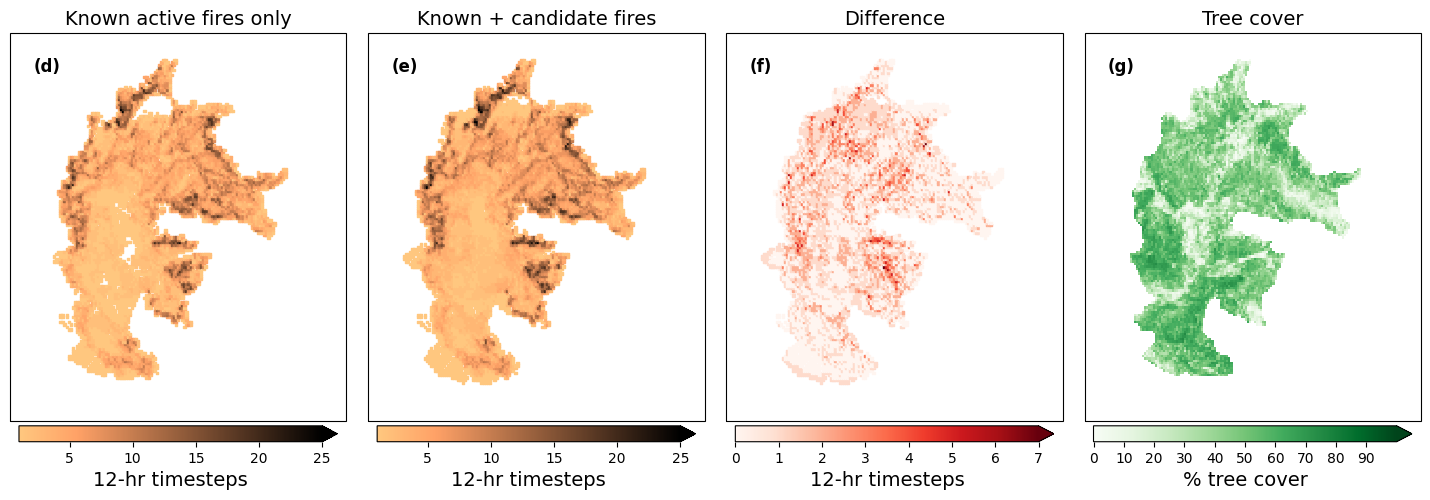

In [16]:
data = dets.copy()

data = data[data.Incid_Name=='CREEK']
extent = [-119.6,-118.8,36.9,37.7]

#round to nearest 0.005 degree for a grid: multiply by 2, round to 2 decimals, divide by 2
data.longitude = (data.longitude*2).round(2) / 2
data.latitude = (data.latitude*2).round(2) / 2

#known dets only
subset = data[data.confidence!='x']
subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
subset['counts'] = 1
subset = subset.groupby(['longitude','latitude']).sum().reset_index()

#all dets
all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
all_dets['counts'] = 1
all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()

#fill in zeros
subset = subset.set_index(['longitude','latitude'])
all_dets = all_dets.set_index(['longitude','latitude'])
all_dets['counts_filled'] = 0
all_dets.loc[subset.index, 'counts_filled'] = subset.loc[subset.index, 'counts']
all_dets = all_dets.reset_index()
subset = subset.reset_index()

m1 = all_dets.counts_filled.mean()
m2 = all_dets.counts.mean()

fig = plt.figure(figsize=(19,6))
grid = gs.GridSpec(1,4)#, width_ratios=[1.2,1.2,1.2,1.2])

ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax.set_extent(extent)
plot = ax.scatter(subset.longitude, subset.latitude, c=subset.counts, s=3, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax.set_title('Known active fires only', size=14)
ax.text(0.07, 0.9, '(d)', transform=ax.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,55,5), extend='max').set_label(label='12-hr timesteps',size=14)

ax2 = plt.subplot(grid[1], projection = ccrs.Miller())
ax2.set_extent(extent)
plot = ax2.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts, s=3, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax2.set_title('Known + candidate fires', size=14)
ax2.text(0.07, 0.9, '(e)', transform=ax2.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,55,5), extend='max').set_label(label='12-hr timesteps',size=14)

print('{:.2f}% more persistence including candidates'.format((m2-m1)/m1*100))

ax3 = plt.subplot(grid[2], projection = ccrs.Miller())
ax3.set_extent(extent)
plot = ax3.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts - all_dets.counts_filled, s=3, vmin=0, vmax=7, marker='s', transform=ccrs.Geodetic(), cmap='Reds')
ax3.set_title('Difference', size=14)
ax3.text(0.07, 0.9, '(f)', transform=ax3.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,8), extend='max').set_label(label='12-hr timesteps',size=14)

#axis4 for tree cover
#tree = xr.open_rasterio('/home/scoffie1/nlcd_tree_cover_creek_2016-3.tif')[0,:,:]
tree = xr.open_rasterio('/home/scoffie1/nlcd_creek_clipped3.tif')[0,:,:]
tree = tree.where(tree > 0) - 1 #shifted by 1 from QGIS to distinguish zeros inside
ax4 = plt.subplot(grid[3], projection = ccrs.Miller())
plot = ax4.pcolormesh(tree.x, tree.y, tree, vmin=0, vmax=100, cmap='Greens', transform=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.set_title('Tree cover', size=14)
ax4.text(0.07, 0.9, '(g)', transform=ax4.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,100,10), extend='max').set_label(label='% tree cover',size=14)

for axs in [ax,ax2,ax3,ax4]:
    axs.set_anchor('N')

plt.subplots_adjust(wspace=-0.1)

#plt.tight_layout()
#plt.savefig('/home/scoffie1/figures/persistence_creek.png', dpi=150)

#next: calculate maximum consecutive days burning for each pixel

In [18]:
#similar for other fires - calculate mean fire duration per pixel
warnings.filterwarnings('ignore')

for fire in range(20):
    
    data = dets[dets.Incid_Name==feds.loc[fire,'Incid_Name']]

    #round to nearest 0.005 degree for a grid: multiply by 2, round to 2 decimals, divide by 2
    data.longitude = (data.longitude*2).round(2) / 2
    data.latitude = (data.latitude*2).round(2) / 2

    #all dets
    all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
    all_dets['counts'] = 1
    all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()
    m2 = all_dets.counts.mean()
    
    feds.loc[fire,'mean_duration'] = m2

#again for "totals" row ------
data = dets.copy()
data.longitude = (data.longitude*2).round(2) / 2
data.latitude = (data.latitude*2).round(2) / 2

#all dets
all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
all_dets['counts'] = 1
all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()

m2 = all_dets.counts.mean()

feds.loc['total','mean_duration'] = m2
feds

,fireid,farea,startdate,enddate,Incid_Name,geometry,n_cand,n_total,perc_cand,perc_frp,mean_duration
0,F11445,4493.471804,2020-08-17 00:00:00,2020-11-25 00:00:00,AUGUST COMPLEX,"POLYGON ((-123.53943 40.27585, -123.53955 40.2...",10812.0,76062.0,14.214720,3.275915,3.010603
1,F11440,1894.388484,2020-08-17 00:00:00,2020-10-29 12:00:00,LIONSHEAD,"POLYGON ((-122.63453 44.78792, -122.63473 44.7...",6065.0,30560.0,19.846204,4.843974,2.560991
2,F12649,1768.278704,2020-09-05 00:00:00,2020-11-26 00:00:00,CREEK,"POLYGON ((-119.50743 37.38098, -119.50743 37.3...",9630.0,49621.0,19.407106,6.883390,4.770968
3,F11393,1526.054850,2020-08-16 12:00:00,2020-09-27 12:00:00,SCU LIGHTNING COMPLEX,"POLYGON ((-121.81677 37.46370, -121.81680 37.4...",3454.0,13143.0,26.280149,3.041689,1.620509
4,F11527,1400.560920,2020-08-18 00:00:00,2020-10-29 12:00:00,CLAREMONT,"POLYGON ((-121.49817 39.64681, -121.49862 39.6...",3426.0,19845.0,17.263794,4.607538,2.717703
5,F11529,1264.748675,2020-08-18 00:00:00,2020-09-21 12:00:00,HENNESSEY,"POLYGON ((-122.59634 38.68418, -122.59686 38.6...",1610.0,8946.0,17.996870,2.333156,1.388616
6,F12774,1016.807124,2020-09-07 00:00:00,2020-10-02 12:00:00,COLD SPRINGS,"MULTIPOLYGON (((-120.01616 47.92316, -120.0153...",2402.0,7402.0,32.450689,9.137569,1.123203
7,F13515,962.841169,2020-08-13 12:00:00,2020-11-13 12:00:00,CAMERON PEAK,"POLYGON ((-105.91946 40.60147, -105.91961 40.6...",3986.0,13916.0,28.643288,5.549800,2.158760
8,F11825,934.392811,2020-08-20 12:00:00,2020-11-27 00:00:00,CASTLE,"POLYGON ((-118.83894 36.29807, -118.83931 36.2...",3764.0,23372.0,16.104741,4.261246,4.441513
9,F12981,804.268938,2019-10-03 00:00:00,2020-10-19 00:00:00,HOLIDAY FARM,"POLYGON ((-122.77847 44.15300, -122.77972 44.1...",2836.0,12793.0,22.168373,7.058933,2.372493


In [20]:
#make pretty and export: Table 1
export = feds.copy()
export['name'] = export.Incid_Name.str.title()
export = export[['name','farea','n_cand','n_total','perc_cand','perc_frp','mean_duration']]
export.to_csv('/home/scoffie1/events_stats_table1.csv',index=False)
export

,name,farea,n_cand,n_total,perc_cand,perc_frp,mean_duration
0,August Complex,4493.471804,10812.0,76062.0,14.214720,3.275915,3.010603
1,Lionshead,1894.388484,6065.0,30560.0,19.846204,4.843974,2.560991
2,Creek,1768.278704,9630.0,49621.0,19.407106,6.883390,4.770968
3,Scu Lightning Complex,1526.054850,3454.0,13143.0,26.280149,3.041689,1.620509
4,Claremont,1400.560920,3426.0,19845.0,17.263794,4.607538,2.717703
5,Hennessey,1264.748675,1610.0,8946.0,17.996870,2.333156,1.388616
6,Cold Springs,1016.807124,2402.0,7402.0,32.450689,9.137569,1.123203
7,Cameron Peak,962.841169,3986.0,13916.0,28.643288,5.549800,2.158760
8,Castle,934.392811,3764.0,23372.0,16.104741,4.261246,4.441513
9,Holiday Farm,804.268938,2836.0,12793.0,22.168373,7.058933,2.372493


In [28]:
#day vs nighttime stats
day = dets[dets.daynight=='D']
night = dets[dets.daynight=='N']

print('daytime', (day.confidence=='x').sum() / len(day) * 100, '% candidates')
print('nighttime', (night.confidence=='x').sum() / len(night) * 100, '% candidates')

print('daytime', (day.confidence=='x').sum() / (day.confidence!='x').sum() * 100, '% boost')
print('nighttime',(night.confidence=='x').sum() / (night.confidence!='x').sum() * 100, '% boost')

daytime 28.999584648007403 % candidates
nighttime 12.310067001922064 % candidates
daytime 40.84424647974055 % boost
nighttime 14.038175855593241 % boost


In [29]:
#day vs nighttime stats
subset = dets[dets.Incid_Name=='CREEK']
day = subset[subset.daynight=='D']
night = subset[subset.daynight=='N']

print('creek fire only')
print('daytime', (day.confidence=='x').sum() / len(day) * 100, '% candidates')
print('nighttime', (night.confidence=='x').sum() / len(night) * 100, '% candidates')

print('daytime', (day.confidence=='x').sum() / (day.confidence!='x').sum() * 100, '% boost')
print('nighttime',(night.confidence=='x').sum() / (night.confidence!='x').sum() * 100, '% boost')

creek fire only
daytime 34.76050307733476 % candidates
nighttime 10.133824670287044 % candidates
daytime 53.28137817883511 % boost
nighttime 11.276572785151613 % boost


In [24]:
len(day)

137233

14.85% more persistence including candidates


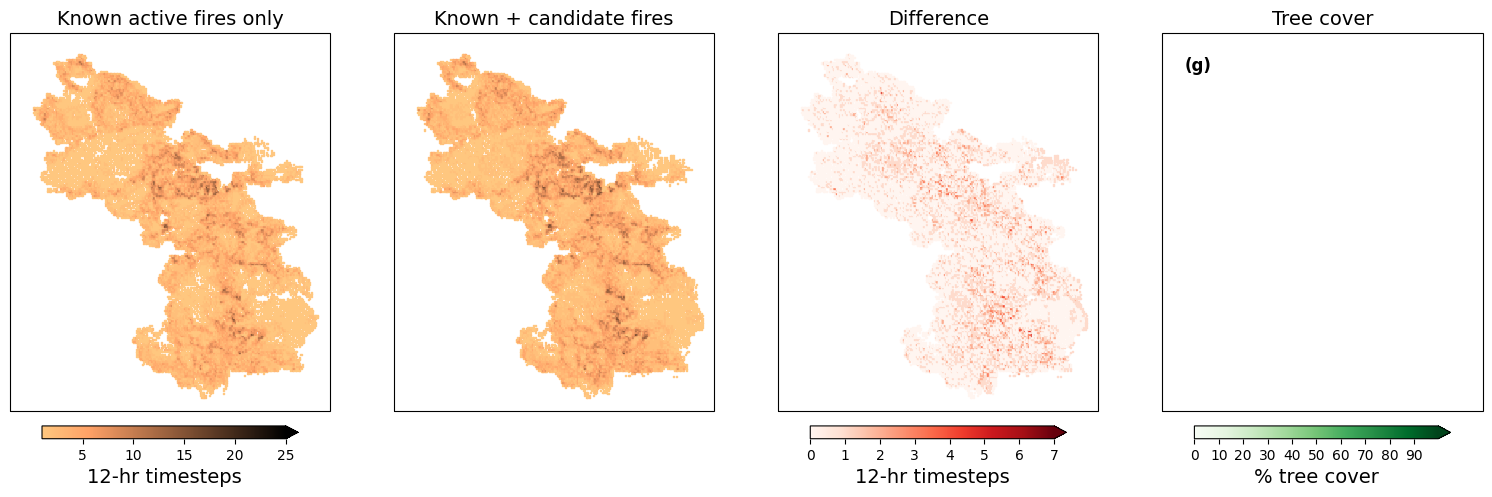

In [38]:
data = dets.copy()

data = data[data.Incid_Name=='AUGUST COMPLEX']
extent = [-123.6, -122.5, 39.4, 40.5]

#round to nearest 0.005 degree for a grid: multiply by 2, round to 2 decimals, divide by 2
data.longitude = (data.longitude*2).round(2) / 2
data.latitude = (data.latitude*2).round(2) / 2

#known dets only
subset = data[data.confidence!='x']
subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
subset['counts'] = 1
subset = subset.groupby(['longitude','latitude']).sum().reset_index()

#all dets
all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
all_dets['counts'] = 1
all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()

#fill in zeros
subset = subset.set_index(['longitude','latitude'])
all_dets = all_dets.set_index(['longitude','latitude'])
all_dets['counts_filled'] = 0
all_dets.loc[subset.index, 'counts_filled'] = subset.loc[subset.index, 'counts']
all_dets = all_dets.reset_index()
subset = subset.reset_index()

m1 = all_dets.counts_filled.mean()
m2 = all_dets.counts.mean()

fig = plt.figure(figsize=(19,6))
grid = gs.GridSpec(1,4)#, width_ratios=[1.2,1.2,1.2,1.2])

ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax.set_extent(extent)
plot = ax.scatter(subset.longitude, subset.latitude, c=subset.counts, s=0.7, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax.set_title('Known active fires only', size=14)
#ax.text(0.07, 0.9, '(d)', transform=ax.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,55,5), extend='max').set_label(label='12-hr timesteps',size=14)

ax2 = plt.subplot(grid[1], projection = ccrs.Miller())
ax2.set_extent(extent)
plot = ax2.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts, s=0.7, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax2.set_title('Known + candidate fires', size=14)
#ax2.text(0.07, 0.9, '(e)', transform=ax2.transAxes, fontweight='bold',fontsize='12')

print('{:.2f}% more persistence including candidates'.format((m2-m1)/m1*100))

ax3 = plt.subplot(grid[2], projection = ccrs.Miller())
ax3.set_extent(extent)
plot = ax3.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts - all_dets.counts_filled, s=0.7, vmin=0, vmax=7, marker='s', transform=ccrs.Geodetic(), cmap='Reds')
ax3.set_title('Difference', size=14)
#ax3.text(0.07, 0.9, '(f)', transform=ax3.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,8), extend='max').set_label(label='12-hr timesteps',size=14)

#axis4 for tree cover
#tree = xr.open_rasterio('/home/scoffie1/nlcd_tree_cover_creek_2016-3.tif')[0,:,:]
tree = xr.open_rasterio('/home/scoffie1/nlcd_creek_clipped3.tif')[0,:,:]
tree = tree.where(tree > 0) - 1 #shifted by 1 from QGIS to distinguish zeros inside
ax4 = plt.subplot(grid[3], projection = ccrs.Miller())
plot = ax4.pcolormesh(tree.x, tree.y, tree, vmin=0, vmax=100, cmap='Greens', transform=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.set_title('Tree cover', size=14)
ax4.text(0.07, 0.9, '(g)', transform=ax4.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,100,10), extend='max').set_label(label='% tree cover',size=14)

for axs in [ax,ax2,ax3,ax4]:
    axs.set_anchor('N')

#plt.subplots_adjust(wspace=0)

#plt.tight_layout()
plt.savefig('/home/scoffie1/figures/persistence_august.png', dpi=150)

#next: calculate maximum consecutive days burning for each pixel

22.17% more persistence including candidates


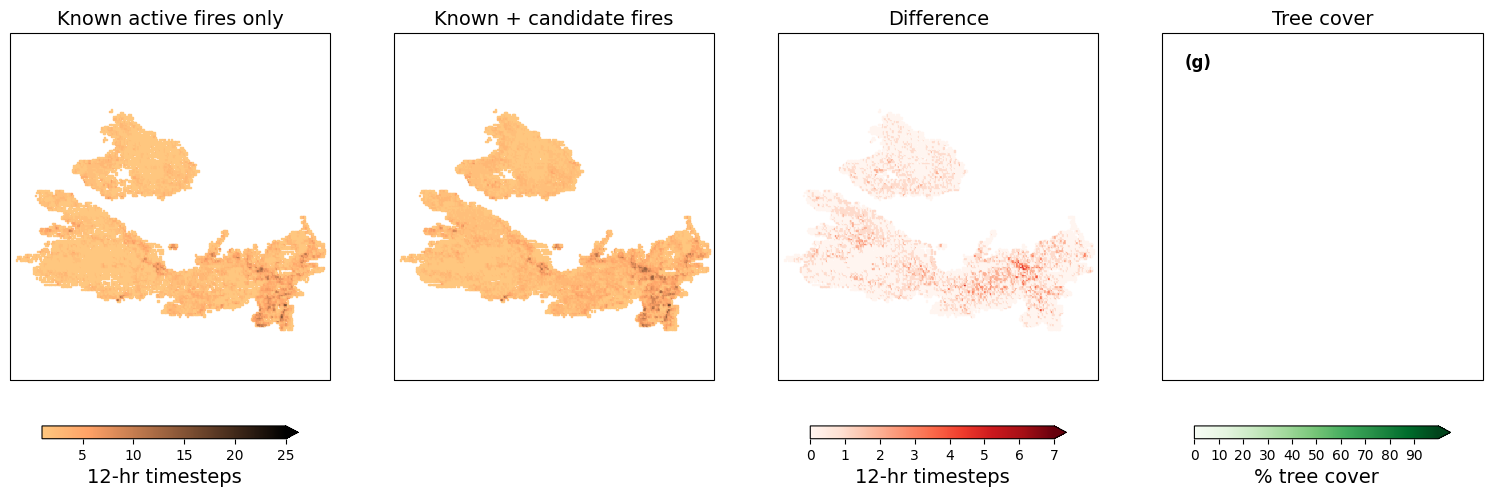

In [35]:
data = dets.copy()
data = data[data.Incid_Name.isin(['RIVERSIDE','LIONSHEAD'])]
extent = [-122.7, -121.5, 44.45, 45.5]

#round to nearest 0.005 degree for a grid: multiply by 2, round to 2 decimals, divide by 2
data.longitude = (data.longitude*2).round(2) / 2
data.latitude = (data.latitude*2).round(2) / 2

#known dets only
subset = data[data.confidence!='x']
subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
subset['counts'] = 1
subset = subset.groupby(['longitude','latitude']).sum().reset_index()

#all dets
all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
all_dets['counts'] = 1
all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()

#fill in zeros
subset = subset.set_index(['longitude','latitude'])
all_dets = all_dets.set_index(['longitude','latitude'])
all_dets['counts_filled'] = 0
all_dets.loc[subset.index, 'counts_filled'] = subset.loc[subset.index, 'counts']
all_dets = all_dets.reset_index()
subset = subset.reset_index()

m1 = all_dets.counts_filled.mean()
m2 = all_dets.counts.mean()

fig = plt.figure(figsize=(19,6))
grid = gs.GridSpec(1,4)#, width_ratios=[1.2,1.2,1.2,1.2])

ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax.set_extent(extent)
plot = ax.scatter(subset.longitude, subset.latitude, c=subset.counts, s=1, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax.set_title('Known active fires only', size=14)
#ax.text(0.07, 0.9, '(d)', transform=ax.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,55,5), extend='max').set_label(label='12-hr timesteps',size=14)

ax2 = plt.subplot(grid[1], projection = ccrs.Miller())
ax2.set_extent(extent)
plot = ax2.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts, s=1, vmin=1, vmax=25, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax2.set_title('Known + candidate fires', size=14)
#ax2.text(0.07, 0.9, '(e)', transform=ax2.transAxes, fontweight='bold',fontsize='12')

print('{:.2f}% more persistence including candidates'.format((m2-m1)/m1*100))

ax3 = plt.subplot(grid[2], projection = ccrs.Miller())
ax3.set_extent(extent)
plot = ax3.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts - all_dets.counts_filled, s=1, vmin=0, vmax=7, marker='s', transform=ccrs.Geodetic(), cmap='Reds')
ax3.set_title('Difference', size=14)
#ax3.text(0.07, 0.9, '(f)', transform=ax3.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,8), extend='max').set_label(label='12-hr timesteps',size=14)

#axis4 for tree cover
#tree = xr.open_rasterio('/home/scoffie1/nlcd_tree_cover_creek_2016-3.tif')[0,:,:]
tree = xr.open_rasterio('/home/scoffie1/nlcd_creek_clipped3.tif')[0,:,:]
tree = tree.where(tree > 0) - 1 #shifted by 1 from QGIS to distinguish zeros inside
ax4 = plt.subplot(grid[3], projection = ccrs.Miller())
plot = ax4.pcolormesh(tree.x, tree.y, tree, vmin=0, vmax=100, cmap='Greens', transform=ccrs.PlateCarree())
ax4.set_extent(extent)
ax4.set_title('Tree cover', size=14)
ax4.text(0.07, 0.9, '(g)', transform=ax4.transAxes, fontweight='bold',fontsize='12')
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.8, pad=0.01, ticks=np.arange(0,100,10), extend='max').set_label(label='% tree cover',size=14)

for axs in [ax,ax2,ax3,ax4]:
    axs.set_anchor('N')

#plt.subplots_adjust(wspace=0)

#plt.tight_layout()
plt.savefig('/home/scoffie1/figures/persistence_oregon.png', dpi=150)

/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/4087539441.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/4087539441.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subset = subset.groupby(['longitude','latitude']).sum().reset_index()
/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/4087539441.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, n

21.11% more persistence including candidates


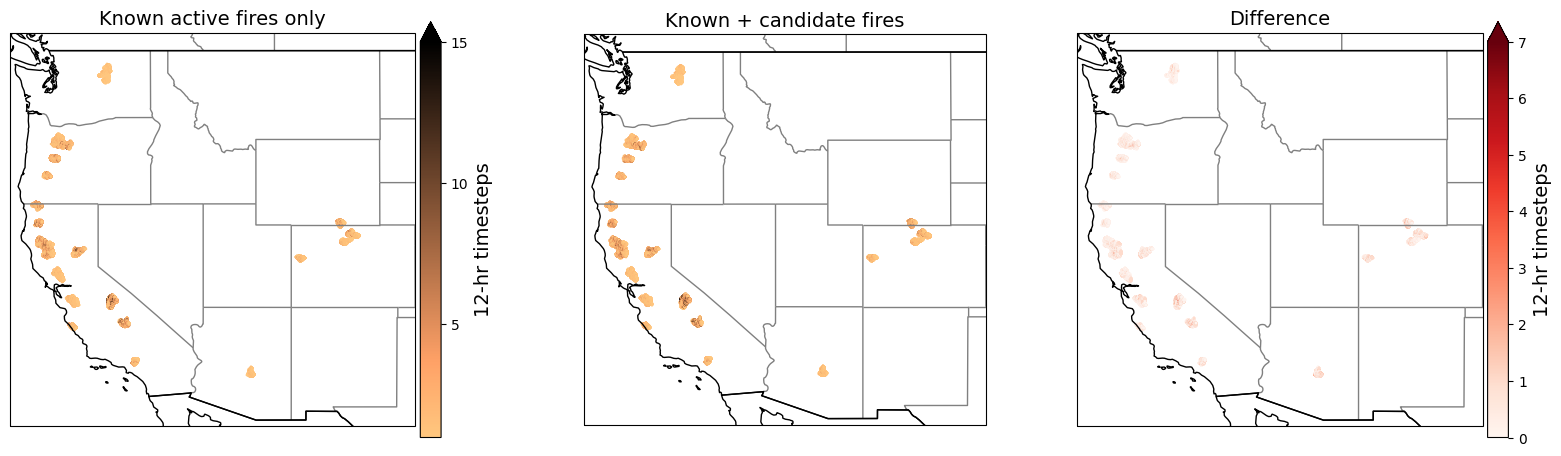

In [28]:
extent = [-125,-102,31,49.2] #western us

data = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_final.csv')

#nearest 0.005 degree: multiply by 2, round to 2 decimals, divide by 2
data.longitude = (data.longitude*2).round(2) / 2
data.latitude = (data.latitude*2).round(2) / 2

#known dets only
subset = data[data.confidence!='x']
subset = subset.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
subset['counts'] = 1
subset = subset.groupby(['longitude','latitude']).sum().reset_index()

#all dets
all_dets = data.groupby(['longitude','latitude','acq_date','daynight']).mean().reset_index()
all_dets['counts'] = 1
all_dets = all_dets.groupby(['longitude','latitude']).sum().reset_index()
#this would more aptly be called "all pixels" at this point

#fill in zeros in "all_dets" where there is no existing entry in the knowns subset
subset = subset.set_index(['longitude','latitude'])
all_dets = all_dets.set_index(['longitude','latitude'])
all_dets['counts_filled'] = 0
all_dets.loc[subset.index, 'counts_filled'] = subset.loc[subset.index, 'counts'] 
#^could call it "counts previously", either the number of counts from the corresponding "known" subset or zero
all_dets = all_dets.reset_index()
subset = subset.reset_index()

m1 = all_dets.counts_filled.mean()
m2 = all_dets.counts.mean()

fig = plt.figure(figsize=(20,9))
grid = gs.GridSpec(1,3, width_ratios=[1.2,1,1.2])

ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax.set_extent(extent)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(countries)
plot = ax.scatter(subset.longitude, subset.latitude, c=subset.counts, s=0.5, vmin=1, vmax=15, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax.set_title('Known active fires only', size=14)
cbar = plt.colorbar(plot, orientation='vertical', shrink=0.6, pad=0.01, ticks=np.arange(0,55,5), extend='max').set_label(label='12-hr timesteps',size=14)

ax2 = plt.subplot(grid[1], projection = ccrs.Miller())
ax2.set_extent(extent)
ax2.add_feature(states_provinces, edgecolor='gray')
ax2.add_feature(countries)
plot = ax2.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts, s=0.5, vmin=1, vmax=15, marker='s', transform=ccrs.Geodetic(), cmap='copper_r')
ax2.set_title('Known + candidate fires', size=14)
print('{:.2f}% more persistence including candidates'.format((m2-m1)/m1*100))

ax3 = plt.subplot(grid[2], projection = ccrs.Miller())
ax3.set_extent(extent)
ax3.add_feature(states_provinces, edgecolor='gray')
ax3.add_feature(countries)
plot = ax3.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.counts - all_dets.counts_filled, s=0.5, vmin=0, vmax=7, marker='s', transform=ccrs.Geodetic(), cmap='Reds')
ax3.set_title('Difference', size=14)
cbar = plt.colorbar(plot, orientation='vertical', shrink=0.6, pad=0.01, ticks=np.arange(0,8), extend='max').set_label(label='12-hr timesteps',size=14)

#plt.savefig('/home/scoffie1/figures/persistence.png', dpi=200)

#next: calculate maximum consecutive days burning for each pixel

In [ ]:
print('new persistence, old persistence', m2, m1)

<h2>Tree cover

In [17]:
#try opening tree cover geotiff
tree = xr.open_rasterio('/discover/nobackup/scoffie1/pct_tree-merged.tif')[0,:,:]
tree.x

/gpfsm/dnb33/tdirs/batch/slurm.34990753.scoffie1/ipykernel_11992/1401796329.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  tree = xr.open_rasterio('/discover/nobackup/scoffie1/pct_tree-merged.tif')[0,:,:]


<xarray.DataArray 'x' (x: 28179)>
array([-126.910839, -126.909941, -126.909043, ..., -101.599908, -101.599009,
       -101.598111])
Coordinates:
    band     int64 1
  * x        (x) float64 -126.9 -126.9 -126.9 -126.9 ... -101.6 -101.6 -101.6

In [18]:
all_dets = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_final.csv')
all_dets.head()

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,j,i750,j750,frp_old,frp,dist_m13b,fireid,Incid_Name
0,-122.674805,39.765137,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
1,-122.675780,39.768494,2,D,x,2020-08-16,2054,3606,2675,1803,NaN,2.505991,1.746884,F11445,AUGUST COMPLEX
2,-122.691410,39.774660,8,N,n,2020-08-17,912,959,3114,479,2.454743,2.454743,NaN,F11445,AUGUST COMPLEX
3,-122.685550,39.774353,8,N,n,2020-08-17,912,960,3114,480,5.806045,5.806045,NaN,F11445,AUGUST COMPLEX
4,-122.680664,39.774110,9,N,h,2020-08-17,912,961,3114,480,5.806045,5.806045,NaN,F11445,AUGUST COMPLEX


In [19]:
#extract tree cover for each point
x = all_dets.longitude.to_xarray()
y = all_dets.latitude.to_xarray()
all_dets['tree_cover'] = tree.sel(x=x, y=y, method='nearest').data

In [21]:
#cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['data_dir']

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none', name='admin_0_countries')

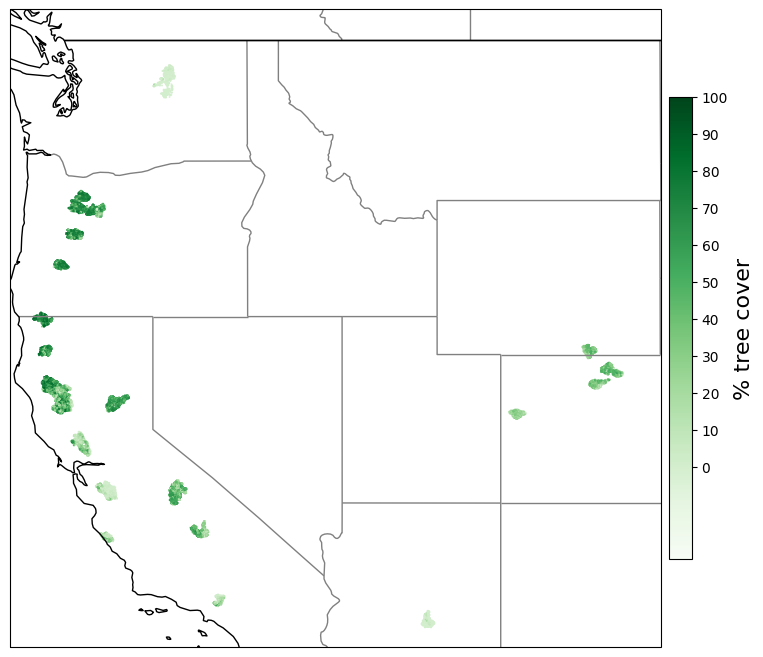

In [27]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection = ccrs.Miller())
ax.set_extent([-124.5,-104,33,49.3])
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(countries)
plot = ax.scatter(all_dets.longitude, all_dets.latitude, c=all_dets.tree_cover, s=0.01, vmin=-25, vmax=100, marker='s', transform=ccrs.Geodetic(), cmap='Greens')
cbar = plt.colorbar(plot, orientation='vertical', shrink=0.6, pad=0.01, ticks=np.arange(0,101,10)).set_label(label='% tree cover',size=16)